## Packages

- numpy: https://numpy.org/
- pandas: https://pandas.pydata.org/
- matplotlib: https://matplotlib.org/
- sklearn: https://scikit-learn.org/stable/index.html
- umap: https://umap-learn.readthedocs.io/en/latest/
- hdbscan: https://pypi.org/project/hdbscan/
- optuna: https://optuna.org/

In [1]:
# Numerical
import numpy as np

# Tabular
import pandas as pd

# Machine learning
from sklearn.preprocessing import StandardScaler
import hdbscan
import optuna
import umap

# Visual
import matplotlib.pyplot as plt

/home/ricky/miniconda3/envs/pop/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample

In [5]:
data = pd.read_csv('Ricardo Full Samples/sample_A_m12f-lsr0.csv')
interest = ['age','feh','alpha','V','UW']

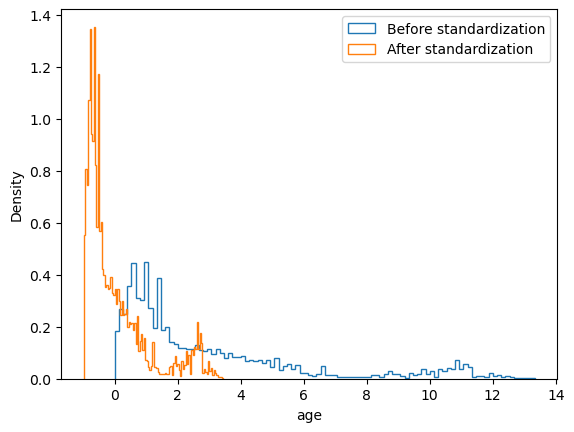

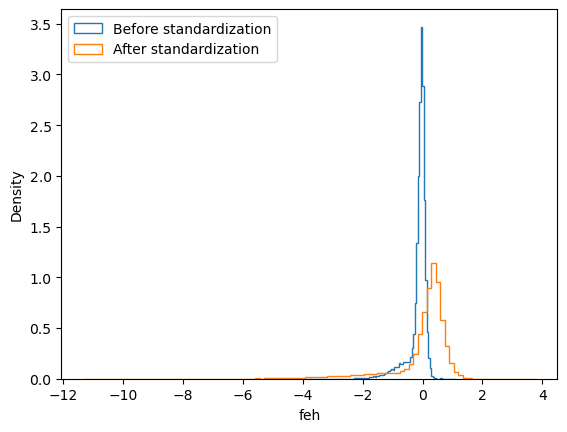

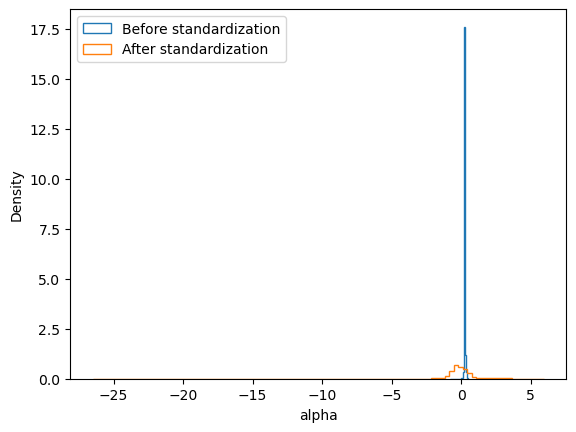

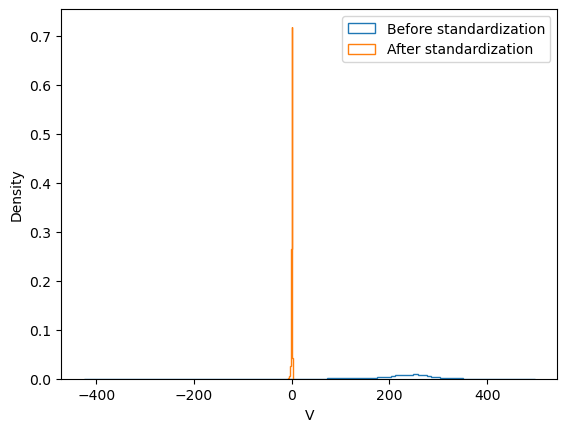

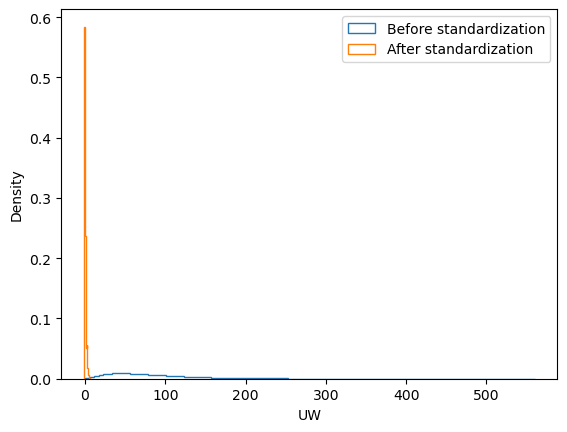

In [9]:
# It is good practice to standardize the data
# There are many different types of standardization
X = StandardScaler().fit_transform(data[interest])

hist_kwargs = {
    'histtype' : 'step',
    'bins'     : 100,
    'density'  : True
}


for i in range(len(interest)):
    plt.hist(
        data[interest].values[:, i],
        label = 'Before standardization',
        **hist_kwargs
    )

    plt.hist(
        X[:, i],
        label = 'After standardization',
        **hist_kwargs
    )

    plt.xlabel(f'{interest[i]}')
    plt.ylabel('Density')
    plt.legend(loc='best')

    plt.show()

## UMAP

See the UMAP paper: https://doi.org/10.48550/arXiv.1802.03426

UMAP(min_dist=0.0, n_epochs=10000, verbose=True)
Tue Jul  1 18:56:23 2025 Construct fuzzy simplicial set
Tue Jul  1 18:56:23 2025 Finding Nearest Neighbors
Tue Jul  1 18:56:23 2025 Building RP forest with 19 trees
Tue Jul  1 18:56:23 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Tue Jul  1 18:56:28 2025 Finished Nearest Neighbor Search
Tue Jul  1 18:56:29 2025 Construct embedding


Epochs completed:   0%|            1/10000 [00:02]

	completed  0  /  10000 epochs


Epochs completed:  10%| █          1001/10000 [04:23]

	completed  1000  /  10000 epochs


Epochs completed:  20%| ██         2001/10000 [08:43]

	completed  2000  /  10000 epochs


Epochs completed:  30%| ███        3001/10000 [13:00]

	completed  3000  /  10000 epochs


Epochs completed:  40%| ████       4001/10000 [17:17]

	completed  4000  /  10000 epochs


Epochs completed:  50%| █████      5001/10000 [21:34]

	completed  5000  /  10000 epochs


Epochs completed:  60%| ██████     6001/10000 [25:51]

	completed  6000  /  10000 epochs


Epochs completed:  70%| ███████    7001/10000 [30:07]

	completed  7000  /  10000 epochs


Epochs completed:  80%| ████████   8001/10000 [34:23]

	completed  8000  /  10000 epochs


Epochs completed:  90%| █████████  9001/10000 [38:41]

	completed  9000  /  10000 epochs


Epochs completed: 100%| ██████████ 10000/10000 [42:58]


Tue Jul  1 19:39:56 2025 Finished embedding


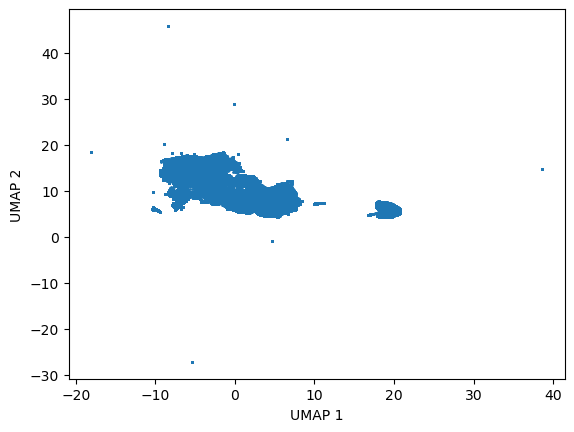

In [10]:
# Define UMAP hyperparameters
hyperparameters = {
    'n_neighbors' : 15,
    'min_dist'    : 0.0,
    'n_epochs'    : 10000,
    'verbose'     : True
}

# Run UMAP
model = umap.UMAP(
    **hyperparameters
)

embedding = model.fit_transform(X)


# Plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

## Trustworthiness, optimized to consume less RAM

Sklearn has a trustworthiness function but it has quadratic RAM consumption. I've redone the function for linear RAM consumption.

See the Trustworthiness paper: https://doi.org/10.1007/3-540-44668-0_68

In [2]:
def trustworthiness_low_memory(
    X, 
    X_embedding, 
    k=15
):
    
    """Calculates the trustworthiness score.

    Parameters
    ----------
    X : Numpy array
        Original space used to construct the embedding.
    X_embedding : Numpy array
        The embedding space.
    k : int
        Number of nearest neighbors for the trustworthiness score.
        
    Returns
    -------
    t_score : float
        The trustworthiness score.
    
    """
    
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    import time
    
    n_samples = X.shape[0]
    
    ## Initialize the Trustworthiness score (t_score)
    t_score = 1
    t_punishment = 0
    punishment_constant = (2.0 / (n_samples * k * (2.0 * n_samples - 3.0 * k - 1.0)))
    
    ## Compute k-Nearest Neighbours in the embedding space
    ## Obtain the indices
    t0 = time.time()
    print('Finding Nearest Neighbours...')
    ind_X_embedded = (
        NearestNeighbors(n_neighbors=k)
        .fit(X_embedding)
        .kneighbors(return_distance=False)
    )
    t1 = time.time()
    print(f'Nearest Neighbours found. Time elapsed: {t1 - t0:.3f} s')
    
    ## For every point i (i_embedding)
    ## There is a neighbourhood kNi in the embedding space (kNi_embedding)
    t0 = time.time()
    for i in range(n_samples):
        #print(f'{i}/{n_samples} n_samples. Trustworthiness score: {t_score}')
        ## Distances from the point i to all the other points in the input (including itself)
        dist_X = np.sqrt(np.sum((X - X[i])**2, axis=1))
        dist_X[i] = np.inf # Exclude the point itself as a neighbor

        ## Indices of sorted distances between i and other samples
        ind_X = np.argsort(dist_X)

        ## Ranks r(i, j) in the input
        ranks = np.where(np.isin(ind_X, ind_X_embedded[i]))[0]
        
        ## Trustworthiness score (punishment part)
        #t_punishment += np.sum(ranks[ranks > 0])
        t_punishment += np.sum(np.maximum(0, ranks - k))
    t_score -= t_punishment * punishment_constant
    t1 = time.time()
    print(f'T(k = {k}) = {t_score:.6f} after {i+1} iterations in {t1 - t0:.3f} seconds.')
    return t_score

In [12]:
# Make sure that the original space is the one you plugged into the UMAP
t_score = trustworthiness_low_memory(
    X           = X , 
    X_embedding = embedding, 
    k           = 15
)

Finding Nearest Neighbours...
Nearest Neighbours found. Time elapsed: 0.564 s
T(k = 15) = 0.986008 after 75000 iterations in 1036.664 seconds.


## HDBSCAN

See the HBDSCAN papers: 
- https://doi.org/10.1007/978-3-642-37456-2_14
- https://doi.org/10.1109/ICDMW.2017.12

## Optuna

It is a hyperparameter optimization package. This will be used to optimize the HDBSCAN hyperparameters.

See the paper: https://doi.org/10.1145/3292500.3330701

In [10]:
# Define the objective function for Optuna
def objective(trial, X):
    
    # Define hyperparams
    min_cluster_size = trial.suggest_int(
        name = 'min_cluster_size', 
        low  = 1000, 
        high = 1500
    )
    min_samples = trial.suggest_int(
        name = 'min_samples', 
        low  = 1, 
        high = 2000 
    )
    # cluster_selection_method = trial.suggest_categorical(
    #     name    = 'cluster_selection_method',
    #     choices = ['eom']
    # )
    # cluster_selection_epsilon = trial.suggest_float(
    #     'cluster_selection_epsilon', 
    #     low  = 0.0,
    #     high = 0.0
    # )
    # allow_single_cluster = trial.suggest_categorical(
    #     name    = 'allow_single_cluster',
    #     choices = [False]
    # )
    
    hyperparams = {
        'min_cluster_size'          : min_cluster_size,
        'min_samples'               : min_samples,
        'cluster_selection_method'  : 'eom',
        'cluster_selection_epsilon' : 0.0,
        'allow_single_cluster'      : False
    }
    
    # Initialize HDBSCAN with suggested hyperparameters
    clusterer = hdbscan.HDBSCAN(
        **hyperparams
    )
    
    # Fit HDBSCAN to the data
    clusterer.fit(X)

    # Handle cases where the algorithm returns no clusters (e.g., all noise)
    if len(np.unique(clusterer.labels_)) <= 1:
        return -np.inf  # Return a very poor score
    else:
        # Calculate the cluster persistence score (built-in for HDBSCAN)
        persistence = np.mean(clusterer.cluster_persistence_)
        # Handle cases where the score is somehow anomalous (bad clustering)
        if abs(persistence) > 1:
            return -np.inf
        # Return the persistence score
        else:
            return persistence

sampler=optuna.samplers.RandomSampler()

In [14]:
# Do not show the logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Number of optuna trials
n_trials = 500

sampler=optuna.samplers.RandomSampler()
# Set up the Optuna study
study_name = f'Sample_HDBSCAN'
study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# Run study (on the embedding)
study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# Get best params and score
best_params = study.best_params
score = study.best_value

print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

  0%|          | 0/500 [00:00<?, ?it/s]

Best trial: 57. Best value: 0.67183: 100%|██████████| 500/500 [1:49:11<00:00, 13.10s/it]  

With a final score of 0.672, the best parameters are:
 {'min_cluster_size': 1466, 'min_samples': 78}


In [15]:
# axes = optuna.visualization.matplotlib.plot_slice(study, ['min_cluster_size'])
# axes.set_ylabel('Persistence score')
# axes.set_title('Sample A')
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample A persistance.png',dpi=600)
# plt.show()
# plt.close()

/tmp/ipykernel_861/1731909592.py:1: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
[W 2025-07-01 21:46:26,434] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


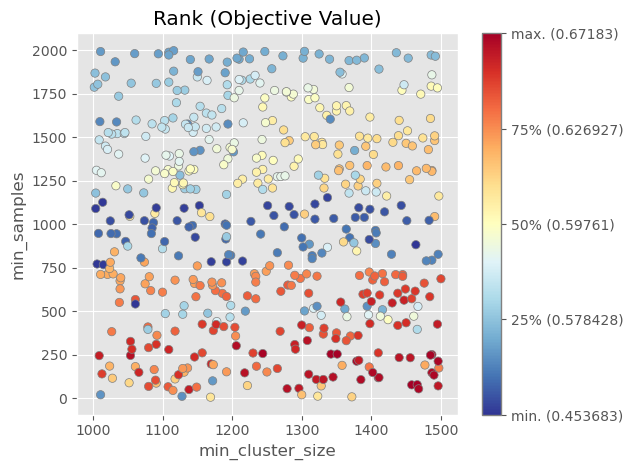

In [16]:
optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample A persistance.png',dpi=600)
plt.show()
plt.close()

/tmp/ipykernel_861/3097639853.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])


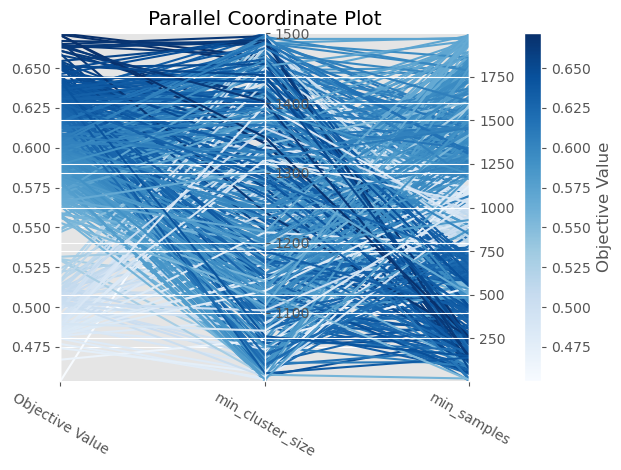

In [17]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample A Coordinate.png',dpi=600)
plt.show()
plt.close()

In [18]:
# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample A Importance.png',dpi=600)
# plt.show()
# plt.close()

In [19]:
# Run HDBSCAN on the embedding
clusterer = hdbscan.HDBSCAN(
        **best_params
    )

clusterer_results = clusterer.fit(embedding)

# Extract labels and persistence score
labels = clusterer_results.labels_
persistence = clusterer_results.cluster_persistence_
persistence_mean = np.mean(clusterer.cluster_persistence_)

data['UMAP1']  = embedding[:, 0]
data['UMAP2']  = embedding[:, 1]
data['labels'] = labels

In [20]:
index = [i for i in range(len(labels)) if labels[i] == -1]
embedding = np.delete(embedding, index,axis=0)
labels = np.delete(labels, index,axis=0)
data = data[data['labels'] != -1]
data.to_csv('Results m12f/Final 1/resultsA.csv', index=False)

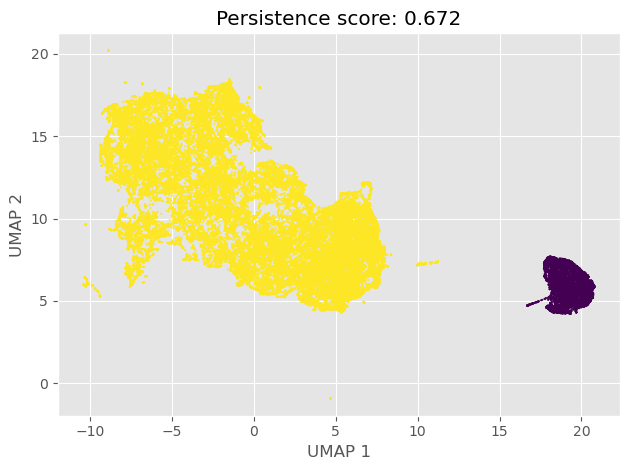

In [21]:
# Plot
plt.title(f'Persistence score: {persistence_mean:.3f}')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
plt.show()
plt.close()

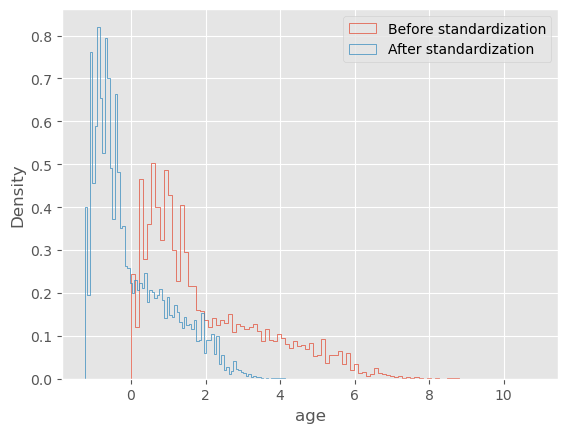

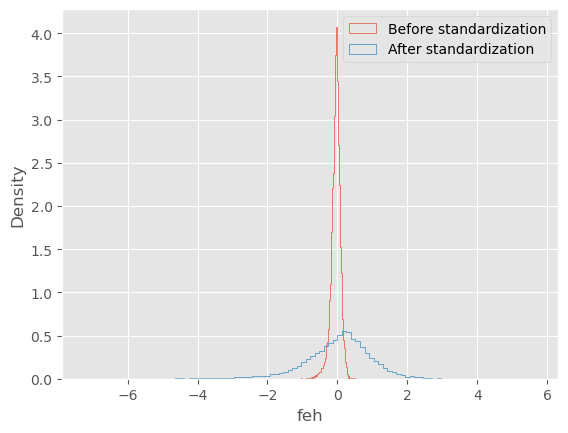

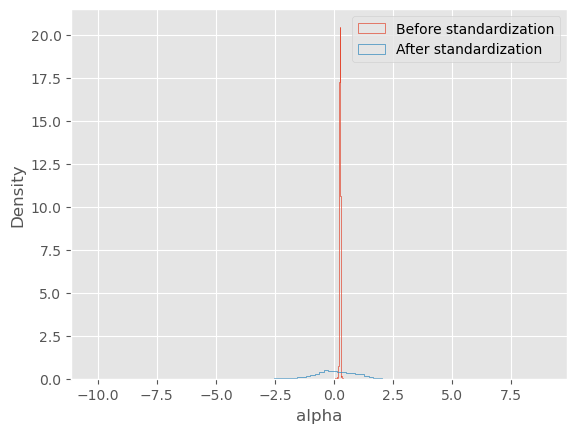

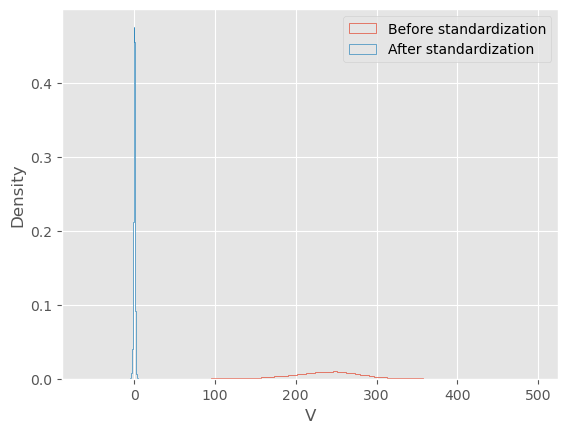

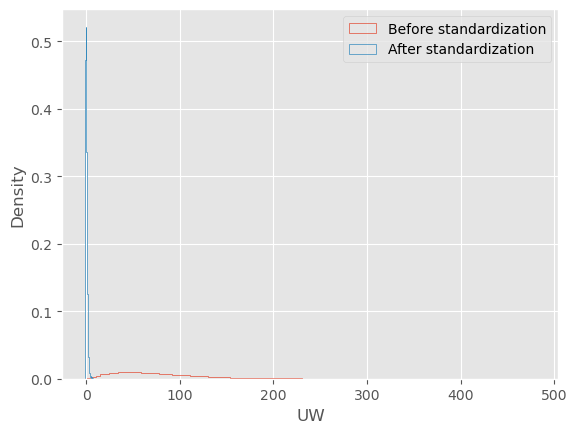

UMAP(min_dist=0.0, n_epochs=10000, verbose=True)
Tue Jul  1 21:46:39 2025 Construct fuzzy simplicial set
Tue Jul  1 21:46:39 2025 Finding Nearest Neighbors
Tue Jul  1 21:46:39 2025 Building RP forest with 18 trees
Tue Jul  1 21:46:39 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Tue Jul  1 21:46:43 2025 Finished Nearest Neighbor Search
Tue Jul  1 21:46:44 2025 Construct embedding


Epochs completed:   0%|            3/10000 [00:02]

	completed  0  /  10000 epochs


Epochs completed:  10%| █          1001/10000 [04:40]

	completed  1000  /  10000 epochs


Epochs completed:  20%| ██         2001/10000 [09:19]

	completed  2000  /  10000 epochs


Epochs completed:  30%| ███        3001/10000 [13:58]

	completed  3000  /  10000 epochs


Epochs completed:  40%| ████       4001/10000 [18:37]

	completed  4000  /  10000 epochs


Epochs completed:  50%| █████      5001/10000 [23:16]

	completed  5000  /  10000 epochs


Epochs completed:  60%| ██████     6001/10000 [28:21]

	completed  6000  /  10000 epochs


Epochs completed:  70%| ███████    7001/10000 [33:44]

	completed  7000  /  10000 epochs


Epochs completed:  80%| ████████   8001/10000 [38:36]

	completed  8000  /  10000 epochs


Epochs completed:  90%| █████████  9001/10000 [43:27]

	completed  9000  /  10000 epochs


Epochs completed: 100%| ██████████ 10000/10000 [48:17]


Tue Jul  1 22:35:12 2025 Finished embedding


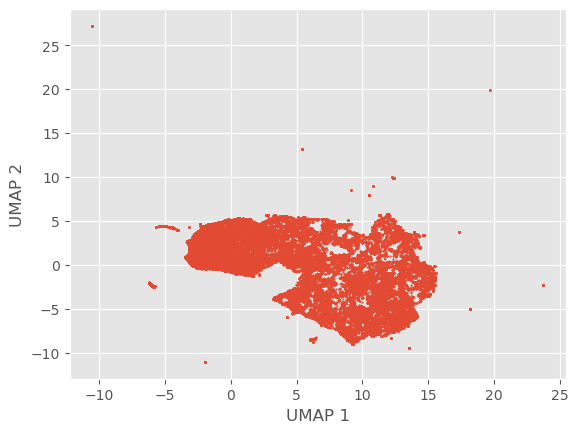

Finding Nearest Neighbours...
Nearest Neighbours found. Time elapsed: 0.448 s
T(k = 15) = 0.988996 after 66414 iterations in 463.996 seconds.


Best trial: 1. Best value: 0.441803: 100%|██████████| 500/500 [1:39:15<00:00, 11.91s/it]  
/tmp/ipykernel_861/2323547998.py:91: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
[W 2025-07-02 00:22:12,815] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


With a final score of 0.442, the best parameters are:
 {'min_cluster_size': 1387, 'min_samples': 894}


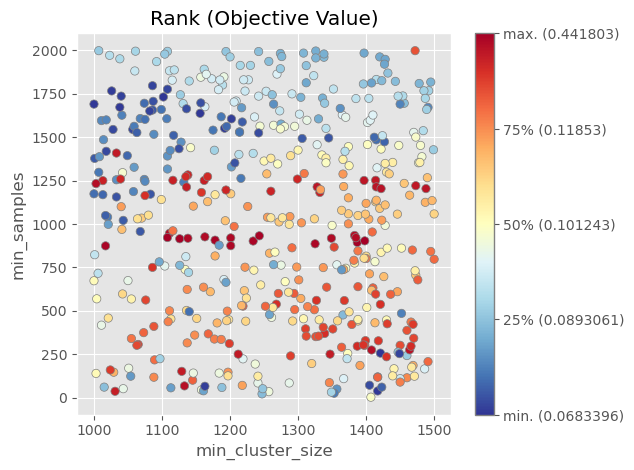

/tmp/ipykernel_861/2323547998.py:98: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])


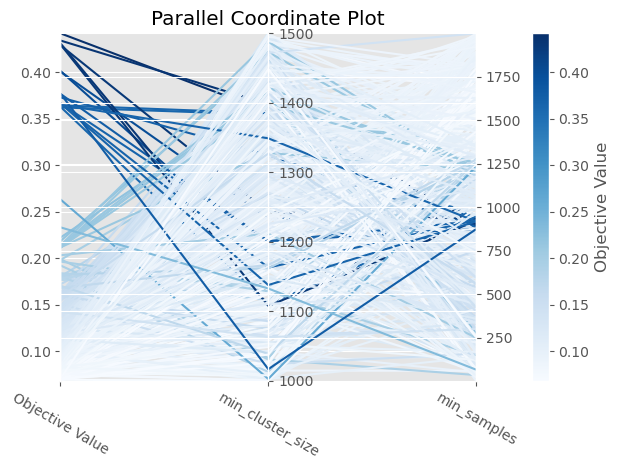

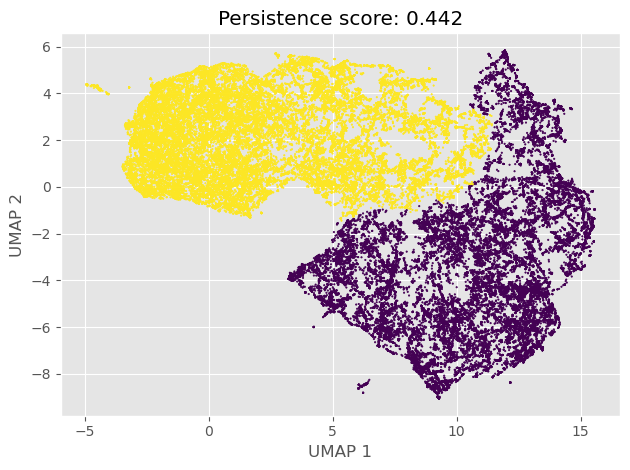

In [22]:
lab = data['labels'].unique()
m = 0
for l in lab:
    if len(data[data['labels'] == m]) < len(data[data['labels'] == l]):
        m = l
data = data[data['labels'] == m]

X = StandardScaler().fit_transform(data[interest])

hist_kwargs = {
    'histtype' : 'step',
    'bins'     : 100,
    'density'  : True
}


for i in range(len(interest)):
    plt.hist(
        data[interest].values[:, i],
        label = 'Before standardization',
        **hist_kwargs
    )

    plt.hist(
        X[:, i],
        label = 'After standardization',
        **hist_kwargs
    )

    plt.xlabel(f'{interest[i]}')
    plt.ylabel('Density')
    plt.legend(loc='best')

    plt.show()
plt.close()

# Define UMAP hyperparameters
hyperparameters = {
    'n_neighbors' : 15,
    'min_dist'    : 0.0,
    'n_epochs'    : 10000,
    'verbose'     : True
}

# Run UMAP
model = umap.UMAP(
    **hyperparameters
)

embedding = model.fit_transform(X)


# Plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()
plt.close()

# Make sure that the original space is the one you plugged into the UMAP
t_score = trustworthiness_low_memory(
    X           = X , 
    X_embedding = embedding, 
    k           = 15
)

# Do not show the logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Number of optuna trials
n_trials = 500

# Set up the Optuna study
study_name = f'Sample_HDBSCAN'
study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# Run study (on the embedding)
study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# Get best params and score
best_params = study.best_params
score = study.best_value

print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample A persistance run 2.png',dpi=600)
plt.show()
plt.close()

optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample A Coordinate run 2.png',dpi=600)
plt.show()
plt.close()

# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample A Importance run 2.png',dpi=600)
# plt.show()
# plt.close()

# Run HDBSCAN on the embedding
clusterer = hdbscan.HDBSCAN(
        **best_params
    )

clusterer_results = clusterer.fit(embedding)

# Extract labels and persistence score
labels = clusterer_results.labels_
persistence = clusterer_results.cluster_persistence_
persistence_mean = np.mean(clusterer.cluster_persistence_)

data['UMAP1']  = embedding[:, 0]
data['UMAP2']  = embedding[:, 1]
data['labels'] = labels

index = [i for i in range(len(labels)) if labels[i] == -1]
embedding = np.delete(embedding, index,axis=0)
labels = np.delete(labels, index,axis=0)
data = data[data['labels'] != -1]
data.to_csv('Results m12f/Final 1/resultsArun2.csv', index=False)

# Plot
plt.title(f'Persistence score: {persistence_mean:.3f}')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
plt.show()
plt.close()

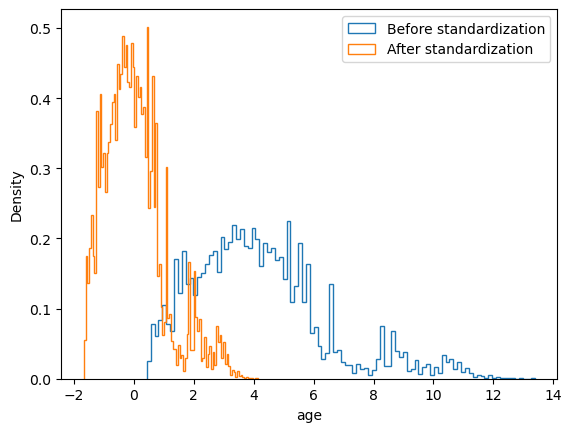

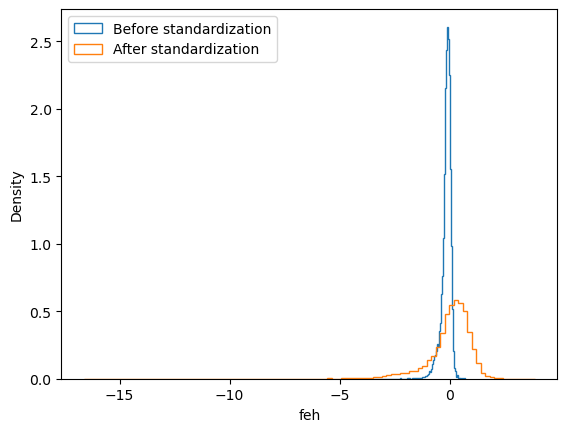

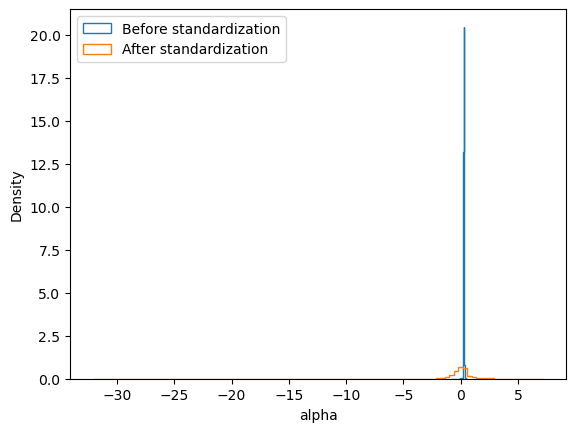

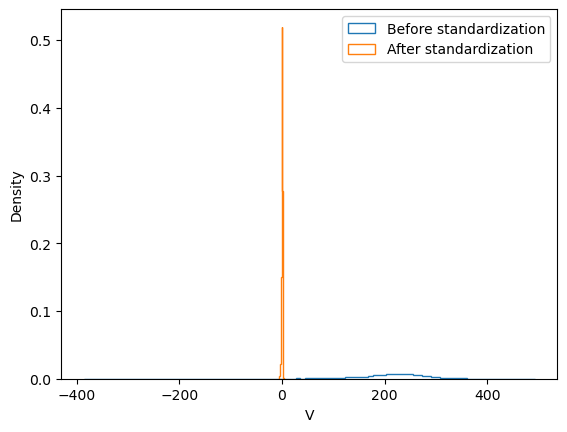

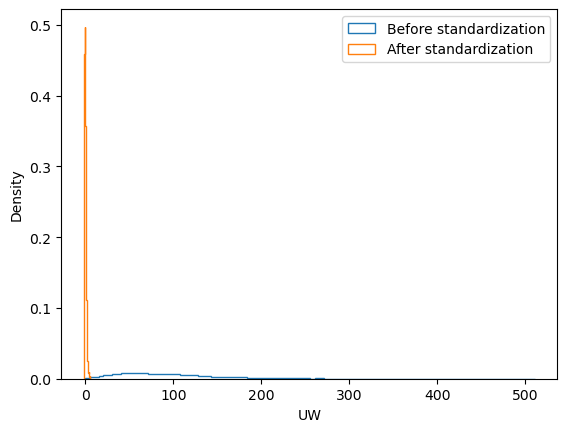

In [6]:
data = pd.read_csv('Ricardo Full Samples/sample_B_m12f-lsr0.csv')
# It is good practice to standardize the data
# There are many different types of standardization
X = StandardScaler().fit_transform(data[interest])

hist_kwargs = {
    'histtype' : 'step',
    'bins'     : 100,
    'density'  : True
}

2000
for i in range(len(interest)):
    plt.hist(
        data[interest].values[:, i],
        label = 'Before standardization',
        **hist_kwargs
    )

    plt.hist(
        X[:, i],
        label = 'After standardization',
        **hist_kwargs
    )

    plt.xlabel(f'{interest[i]}')
    plt.ylabel('Density')
    plt.legend(loc='best')

    plt.show()

UMAP(min_dist=0.0, n_epochs=10000, verbose=True)
Wed Jul  2 01:51:01 2025 Construct fuzzy simplicial set
Wed Jul  2 01:51:01 2025 Finding Nearest Neighbors
Wed Jul  2 01:51:01 2025 Building RP forest with 19 trees
Wed Jul  2 01:51:07 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Wed Jul  2 01:51:39 2025 Finished Nearest Neighbor Search
Wed Jul  2 01:51:44 2025 Construct embedding


Epochs completed:   0%|            3/10000 [00:03]

	completed  0  /  10000 epochs


Epochs completed:  10%| █          1002/10000 [03:16]

	completed  1000  /  10000 epochs


Epochs completed:  20%| ██         2002/10000 [06:22]

	completed  2000  /  10000 epochs


Epochs completed:  30%| ███        3002/10000 [09:20]

	completed  3000  /  10000 epochs


Epochs completed:  40%| ████       4002/10000 [12:17]

	completed  4000  /  10000 epochs


Epochs completed:  50%| █████      5002/10000 [15:12]

	completed  5000  /  10000 epochs


Epochs completed:  60%| ██████     6002/10000 [18:07]

	completed  6000  /  10000 epochs


Epochs completed:  70%| ███████    7002/10000 [21:02]

	completed  7000  /  10000 epochs


Epochs completed:  80%| ████████   8002/10000 [23:56]

	completed  8000  /  10000 epochs


Epochs completed:  90%| █████████  9002/10000 [26:49]

	completed  9000  /  10000 epochs


Epochs completed: 100%| ██████████ 10000/10000 [29:43]


Wed Jul  2 02:21:42 2025 Finished embedding


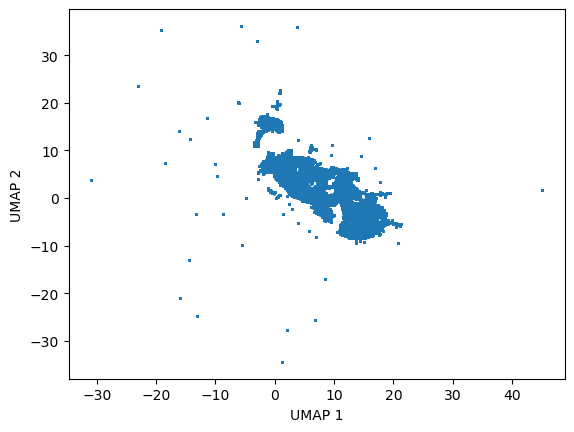

In [7]:
# Define UMAP hyperparameters
hyperparameters = {
    'n_neighbors' : 15,
    'min_dist'    : 0.0,
    'n_epochs'    : 10000,
    'verbose'     : True
}

# Run UMAP
model = umap.UMAP(
    **hyperparameters
)

embedding = model.fit_transform(X)


# Plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

In [8]:
# Make sure that the original space is the one you plugged into the UMAP
t_score = trustworthiness_low_memory(
    X           = X , 
    X_embedding = embedding, 
    k           = 15
)

Finding Nearest Neighbours...
Nearest Neighbours found. Time elapsed: 0.466 s
T(k = 15) = 0.994312 after 76168 iterations in 632.626 seconds.


In [26]:
# # Define the objective function for Optuna
# def objective(intrial, X):
    
#     # Define hyperparams
#     min_cluster_size = trial.suggest_int(
#         name = 'min_cluster_size', 
#         low  = 900, 
#         high = 2500
#     )
#     min_samples = trial.suggest_int(
#         name = 'min_samples', 
#         low  =  1, #int(min_cluster_size / 4), 
#         high = 900
#     )
#     cluster_selection_method = trial.suggest_categorical(
#         name    = 'cluster_selection_method',
#         choices = ['eom']
#     )
#     cluster_selection_epsilon = trial.suggest_float(
#         'cluster_selection_epsilon', 
#         low  = 0.0,
#         high = 0.0
#     )
#     allow_single_cluster = trial.suggest_categorical(
#         name    = 'allow_single_cluster',
#         choices = [False]
#     )
    
#     hyperparams = {
#         'min_cluster_size'          : min_cluster_size,
#         'min_samples'               : min_samples,
#         'cluster_selection_method'  : cluster_selection_method,
#         'cluster_selection_epsilon' : cluster_selection_epsilon,
#         'allow_single_cluster'      : allow_single_cluster
#     }
    
#     # Initialize HDBSCAN with suggested hyperparameters
#     clusterer = hdbscan.HDBSCAN(
#         **hyperparams
#     )
    
#     # Fit HDBSCAN to the data
#     clusterer.fit(X)

#     # Handle cases where the algorithm returns no clusters (e.g., all noise)
#     if len(np.unique(clusterer.labels_)) <= 1:
#         return -np.inf  # Return a very poor score
#     else:
#         # Calculate the cluster persistence score (built-in for HDBSCAN)
#         persistence = np.mean(clusterer.cluster_persistence_)
#         # Handle cases where the score is somehow anomalous (bad clustering)
#         if abs(persistence) > 1:
#             return -np.inf
#         # Return the persistence score
#         else:
#             return persistence

In [12]:
# Do not show the logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Number of optuna trials
n_trials = 500

# Set up the Optuna study
study_name = f'Sample_HDBSCAN'
study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# Run study (on the embedding)
study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# Get best params and score
best_params = study.best_params
score = study.best_value

print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

Best trial: 37. Best value: 0.582938: 100%|██████████| 500/500 [1:26:59<00:00, 10.44s/it]

With a final score of 0.583, the best parameters are:
 {'min_cluster_size': 1460, 'min_samples': 388}


In [13]:
# axes = optuna.visualization.matplotlib.plot_slice(study, ['min_cluster_size'])
# axes.set_ylabel('Persistence score')
# axes.set_title('Sample B')
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample B persistance.png',dpi=600)
# plt.show()
# plt.close()

/tmp/ipykernel_778/3261361513.py:1: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
[W 2025-07-02 04:04:07,124] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


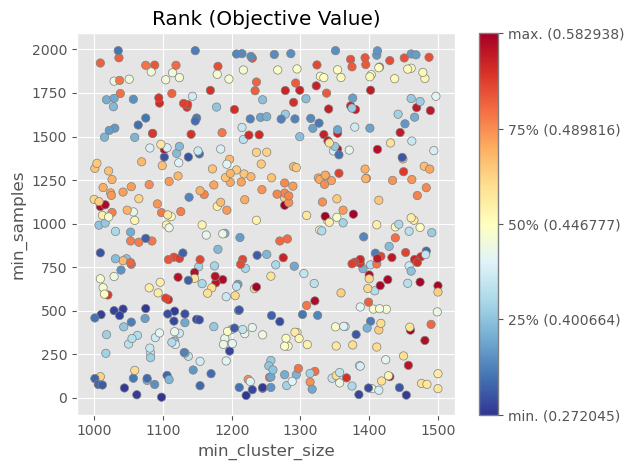

/tmp/ipykernel_778/3261361513.py:8: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])


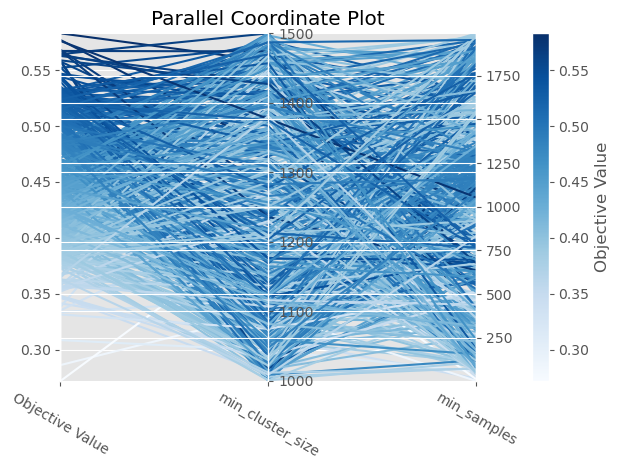

In [14]:
optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample B persistance.png',dpi=600)
plt.show()
plt.close()

optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample B Coordinate.png',dpi=600)
plt.show()
plt.close()

# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.tight_layout()
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample B Importance.png',dpi=600)
# plt.show()
# plt.close()

In [15]:
# Run HDBSCAN on the embedding
clusterer = hdbscan.HDBSCAN(
        **best_params
    )

clusterer_results = clusterer.fit(embedding)

# Extract labels and persistence score
labels = clusterer_results.labels_
persistence = clusterer_results.cluster_persistence_
persistence_mean = np.mean(clusterer.cluster_persistence_)

data['UMAP1']  = embedding[:, 0]
data['UMAP2']  = embedding[:, 1]
data['labels'] = labels

In [16]:
index = [i for i in range(len(labels)) if labels[i] == -1]
embedding = np.delete(embedding, index,axis=0)
labels = np.delete(labels, index,axis=0)
data = data[data['labels'] != -1]
data.to_csv('Results m12f/Final 1/resultsB.csv', index=False)

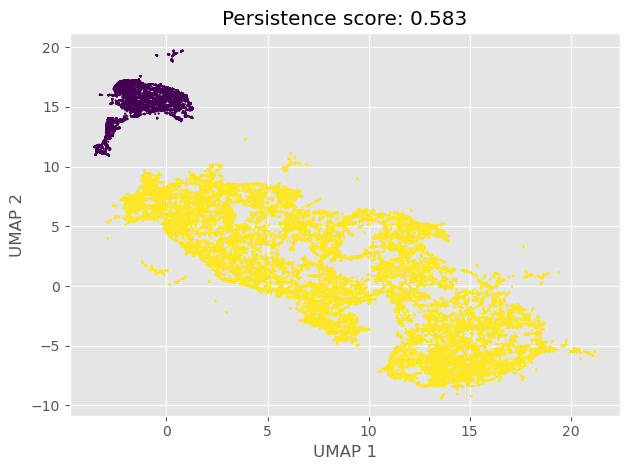

In [17]:
# Plot
plt.title(f'Persistence score: {persistence_mean:.3f}')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
plt.show()
plt.close()

In [18]:
# lab = data['labels'].unique()
# m = 0
# for l in lab:
#     if len(data[data['labels'] == m]) < len(data[data['labels'] == l]):
#         m = l
# data = data[data['labels'] == m]

# X = StandardScaler().fit_transform(data[interest])

# hist_kwargs = {
#     'histtype' : 'step',
#     'bins'     : 100,
#     'density'  : True
# }


# for i in range(len(interest)):
#     plt.hist(
#         data[interest].values[:, i],
#         label = 'Before standardization',
#         **hist_kwargs
#     )

#     plt.hist(
#         X[:, i],
#         label = 'After standardization',
#         **hist_kwargs
#     )

#     plt.xlabel(f'{interest[i]}')
#     plt.ylabel('Density')
#     plt.legend(loc='best')

#     plt.show()
# plt.close()

# # Define UMAP hyperparameters
# hyperparameters = {
#     'n_neighbors' : 15,
#     'min_dist'    : 0.0,
#     'n_epochs'    : 10000,
#     'verbose'     : True
# }

# # Run UMAP
# model = umap.UMAP(
#     **hyperparameters
# )

# embedding = model.fit_transform(X)


# # Plot
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1
# )
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')

# plt.show()
# plt.close()

# # Make sure that the original space is the one you plugged into the UMAP
# t_score = trustworthiness_low_memory(
#     X           = X , 
#     X_embedding = embedding, 
#     k           = 15
# )

# # Do not show the logs
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Number of optuna trials
# n_trials = 500

# # Set up the Optuna study
# study_name = f'Sample_HDBSCAN'
# study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# # Run study (on the embedding)
# study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# # Get best params and score
# best_params = study.best_params
# score = study.best_value

# print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

# optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample B persistance run 2.png',dpi=600)
# plt.show()
# plt.close()

# optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample B Coordinate run 2.png',dpi=600)
# plt.show()
# plt.close()

# # optuna.visualization.matplotlib.plot_param_importances(study)
# # plt.plot()
# # plt.savefig('Results m12f/Final 1/Sample A Importance run 2.png',dpi=600)
# # plt.show()
# # plt.close()

# # Run HDBSCAN on the embedding
# clusterer = hdbscan.HDBSCAN(
#         **best_params
#     )

# clusterer_results = clusterer.fit(embedding)

# # Extract labels and persistence score
# labels = clusterer_results.labels_
# persistence = clusterer_results.cluster_persistence_
# persistence_mean = np.mean(clusterer.cluster_persistence_)

# data['UMAP1']  = embedding[:, 0]
# data['UMAP2']  = embedding[:, 1]
# data['labels'] = labels

# index = [i for i in range(len(labels)) if labels[i] == -1]
# embedding = np.delete(embedding, index,axis=0)
# labels = np.delete(labels, index,axis=0)
# data = data[data['labels'] != -1]
# data.to_csv('Results m12f/Final 1/resultsBrun2.csv', index=False)

# # Plot
# plt.title(f'Persistence score: {persistence_mean:.3f}')
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1,
#     c=labels
# )
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.tight_layout()
# # plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
# plt.show()
# plt.close()

In [19]:
# Define the objective function for Optuna
def objective(trial, X):
    
    # Define hyperparams
    min_cluster_size = trial.suggest_int(
        name = 'min_cluster_size', 
        low  = 500, 
        high = 1000
    )
    min_samples = trial.suggest_int(
        name = 'min_samples', 
        low  =  1, #int(min_cluster_size / 4), 
        high = 2000
    )
    # cluster_selection_method = trial.suggest_categorical(
    #     name    = 'cluster_selection_method',
    #     choices = ['eom']
    # )
    # cluster_selection_epsilon = trial.suggest_float(
    #     'cluster_selection_epsilon', 
    #     low  = 0.0,
    #     high = 0.0
    # )
    # allow_single_cluster = trial.suggest_categorical(
    #     name    = 'allow_single_cluster',
    #     choices = [False]
    # )
    
    hyperparams = {
        'min_cluster_size'          : min_cluster_size,
        'min_samples'               : min_samples,
        'cluster_selection_method'  : 'eom',
        'cluster_selection_epsilon' : 0,
        'allow_single_cluster'      : False
    }
    
    # Initialize HDBSCAN with suggested hyperparameters
    clusterer = hdbscan.HDBSCAN(
        **hyperparams
    )
    
    # Fit HDBSCAN to the data
    clusterer.fit(X)

    # Handle cases where the algorithm returns no clusters (e.g., all noise)
    if len(np.unique(clusterer.labels_)) <= 1:
        return -np.inf  # Return a very poor score
    else:
        # Calculate the cluster persistence score (built-in for HDBSCAN)
        persistence = np.mean(clusterer.cluster_persistence_)
        # Handle cases where the score is somehow anomalous (bad clustering)
        if abs(persistence) > 1:
            return -np.inf
        # Return the persistence score
        else:
            return persistence

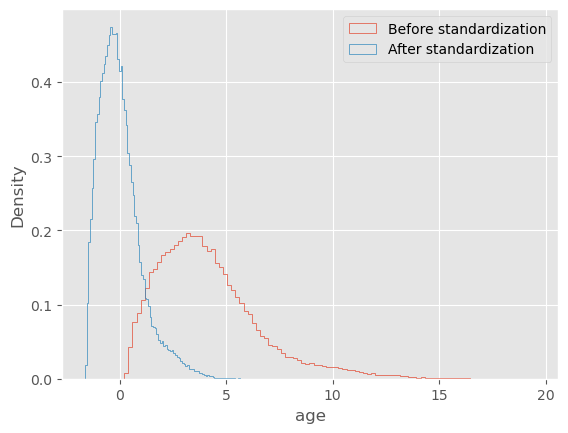

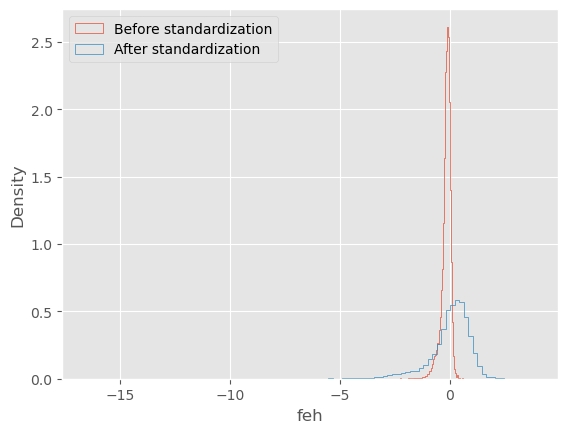

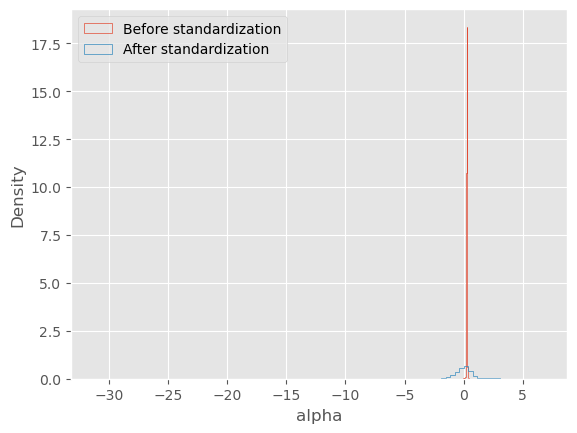

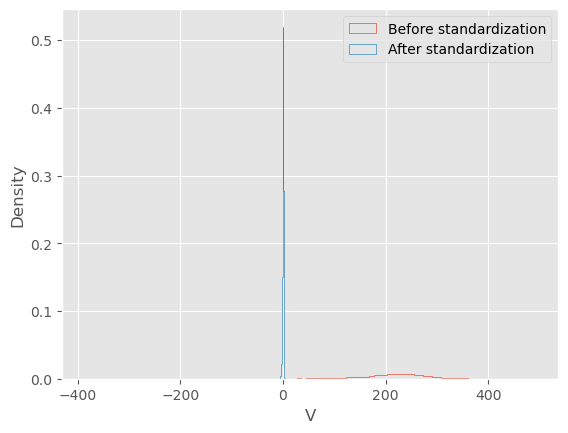

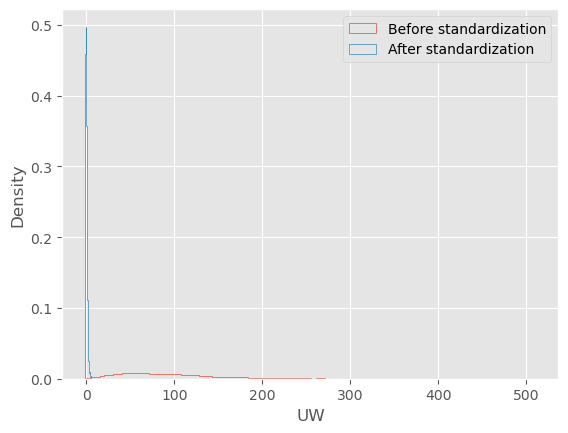

UMAP(min_dist=0.0, n_epochs=10000, verbose=True)
Wed Jul  2 04:04:23 2025 Construct fuzzy simplicial set
Wed Jul  2 04:04:23 2025 Finding Nearest Neighbors
Wed Jul  2 04:04:23 2025 Building RP forest with 19 trees
Wed Jul  2 04:04:23 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Wed Jul  2 04:04:26 2025 Finished Nearest Neighbor Search
Wed Jul  2 04:04:26 2025 Construct embedding


Epochs completed:   0%|            4/10000 [00:02]

	completed  0  /  10000 epochs


Epochs completed:  10%| █          1002/10000 [02:33]

	completed  1000  /  10000 epochs


Epochs completed:  20%| ██         2002/10000 [05:04]

	completed  2000  /  10000 epochs


Epochs completed:  30%| ███        3002/10000 [07:35]

	completed  3000  /  10000 epochs


Epochs completed:  40%| ████       4002/10000 [10:07]

	completed  4000  /  10000 epochs


Epochs completed:  50%| █████      5002/10000 [12:38]

	completed  5000  /  10000 epochs


Epochs completed:  60%| ██████     6002/10000 [15:09]

	completed  6000  /  10000 epochs


Epochs completed:  70%| ███████    7002/10000 [17:39]

	completed  7000  /  10000 epochs


Epochs completed:  80%| ████████   8002/10000 [20:10]

	completed  8000  /  10000 epochs


Epochs completed:  90%| █████████  9002/10000 [22:41]

	completed  9000  /  10000 epochs


Epochs completed: 100%| ██████████ 10000/10000 [25:12]


Wed Jul  2 04:29:44 2025 Finished embedding


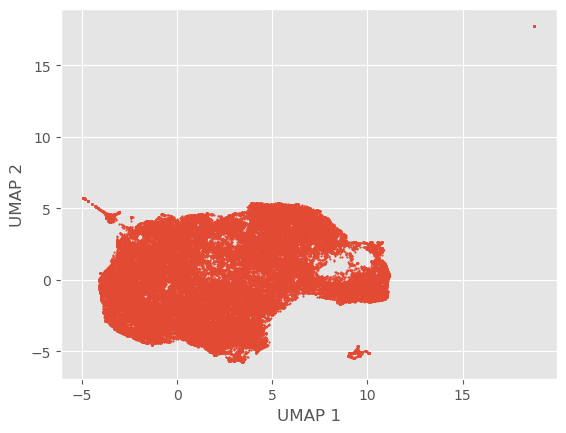

Finding Nearest Neighbours...
Nearest Neighbours found. Time elapsed: 0.364 s
T(k = 15) = 0.969401 after 76168 iterations in 585.573 seconds.


Best trial: 181. Best value: 0.640561: 100%|██████████| 500/500 [1:30:56<00:00, 10.91s/it]
/tmp/ipykernel_778/337645295.py:95: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
[W 2025-07-02 06:10:27,188] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


With a final score of 0.641, the best parameters are:
 {'min_cluster_size': 990, 'min_samples': 111}


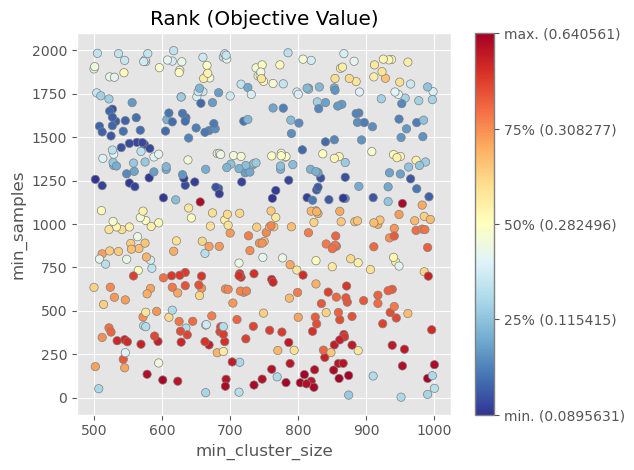

/tmp/ipykernel_778/337645295.py:102: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])


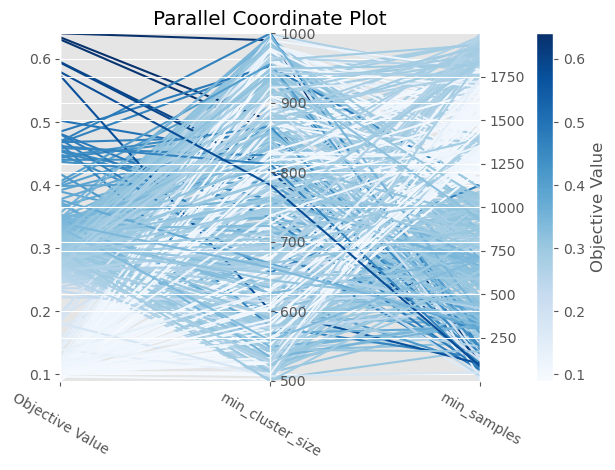

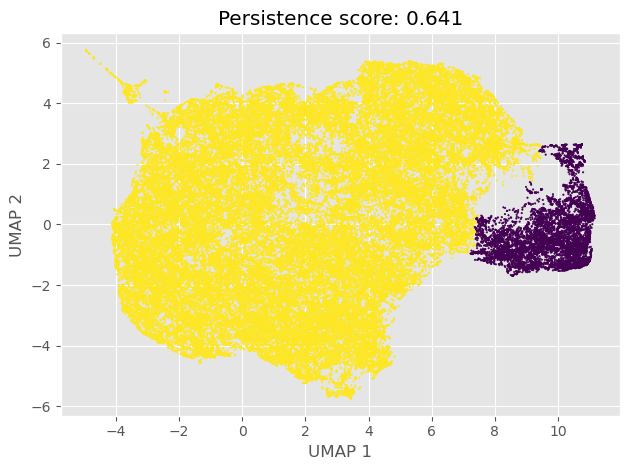

In [20]:
data = pd.read_csv('Ricardo Full Samples/sample_C_m12f-lsr0.csv')
# It is good practice to standardize the data
# There are many different types of standardization
X = StandardScaler().fit_transform(data[interest])

hist_kwargs = {
    'histtype' : 'step',
    'bins'     : 100,
    'density'  : True
}


for i in range(len(interest)):
    plt.hist(
        data[interest].values[:, i],
        label = 'Before standardization',
        **hist_kwargs
    )

    plt.hist(
        X[:, i],
        label = 'After standardization',
        **hist_kwargs
    )

    plt.xlabel(f'{interest[i]}')
    plt.ylabel('Density')
    plt.legend(loc='best')

    plt.show()
plt.close()

# Define UMAP hyperparameters
hyperparameters = {
    'n_neighbors' : 15,
    'min_dist'    : 0.0,
    'n_epochs'    : 10000,
    'verbose'     : True
}

# Run UMAP
model = umap.UMAP(
    **hyperparameters
)

embedding = model.fit_transform(X)


# Plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()
plt.close()

# Make sure that the original space is the one you plugged into the UMAP
t_score = trustworthiness_low_memory(
    X           = X , 
    X_embedding = embedding, 
    k           = 15
)

# Do not show the logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Number of optuna trials
n_trials = 500

# Set up the Optuna study
study_name = f'Sample_HDBSCAN'
study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# Run study (on the embedding)
study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# Get best params and score
best_params = study.best_params
score = study.best_value

print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

# axes = optuna.visualization.matplotlib.plot_slice(study, ['min_cluster_size'])
# axes.set_ylabel('Persistence score')
# axes.set_title('Sample C')
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample C persistance.png',dpi=600)
# plt.show()
# plt.close()

optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample C persistance.png',dpi=600)
plt.show()
plt.close()

optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample C Coordinate.png',dpi=600)
plt.show()
plt.close()

# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample C Importance.png',dpi=600)
# plt.show()
# plt.close()

# Run HDBSCAN on the embedding
clusterer = hdbscan.HDBSCAN(
        **best_params
    )

clusterer_results = clusterer.fit(embedding)

# Extract labels and persistence score
labels = clusterer_results.labels_
persistence = clusterer_results.cluster_persistence_
persistence_mean = np.mean(clusterer.cluster_persistence_)

data['UMAP1']  = embedding[:, 0]
data['UMAP2']  = embedding[:, 1]
data['labels'] = labels

index = [i for i in range(len(labels)) if labels[i] == -1]
embedding = np.delete(embedding, index,axis=0)
labels = np.delete(labels, index,axis=0)
data = data[data['labels'] != -1]
data.to_csv('Results m12f/Final 1/resultsC.csv', index=False)

# Plot
plt.title(f'Persistence score: {persistence_mean:.3f}')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
plt.show()
plt.close()

# lab = data['labels'].unique()
# m = 0
# for l in lab:
#     if len(data[data['labels'] == m]) < len(data[data['labels'] == l]):
#         m = l
# data = data[data['labels'] == m]

# X = StandardScaler().fit_transform(data[interest])

# hist_kwargs = {
#     'histtype' : 'step',
#     'bins'     : 100,
#     'density'  : True
# }


# for i in range(len(interest)):
#     plt.hist(
#         data[interest].values[:, i],
#         label = 'Before standardization',
#         **hist_kwargs
#     )

#     plt.hist(
#         X[:, i],
#         label = 'After standardization',
#         **hist_kwargs
#     )

#     plt.xlabel(f'{interest[i]}')
#     plt.ylabel('Density')
#     plt.legend(loc='best')

#     plt.show()
# plt.close()

# # Define UMAP hyperparameters
# hyperparameters = {
#     'n_neighbors' : 15,
#     'min_dist'    : 0.0,
#     'n_epochs'    : 10000,
#     'verbose'     : True
# }

# # Run UMAP
# model = umap.UMAP(
#     **hyperparameters
# )

# embedding = model.fit_transform(X)


# # Plot
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1
# )
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')

# plt.show()
# plt.close()

# # Make sure that the original space is the one you plugged into the UMAP
# t_score = trustworthiness_low_memory(
#     X           = X , 
#     X_embedding = embedding, 
#     k           = 15
# )

# # Do not show the logs
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Number of optuna trials
# n_trials = 500

# # Set up the Optuna study
# study_name = f'Sample_HDBSCAN'
# study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# # Run study (on the embedding)
# study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# # Get best params and score
# best_params = study.best_params
# score = study.best_value

# print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

# optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample C persistance run 2.png',dpi=600)
# plt.show()
# plt.close()

# optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample C Coordinate run 2.png',dpi=600)
# plt.show()
# plt.close()

# # optuna.visualization.matplotlib.plot_param_importances(study)
# # plt.plot()
# # plt.savefig('Results m12f/Final 1/Sample A Importance run 2.png',dpi=600)
# # plt.show()
# # plt.close()

# # Run HDBSCAN on the embedding
# clusterer = hdbscan.HDBSCAN(
#         **best_params
#     )

# clusterer_results = clusterer.fit(embedding)

# # Extract labels and persistence score
# labels = clusterer_results.labels_
# persistence = clusterer_results.cluster_persistence_
# persistence_mean = np.mean(clusterer.cluster_persistence_)

# data['UMAP1']  = embedding[:, 0]
# data['UMAP2']  = embedding[:, 1]
# data['labels'] = labels

# index = [i for i in range(len(labels)) if labels[i] == -1]
# embedding = np.delete(embedding, index,axis=0)
# labels = np.delete(labels, index,axis=0)
# data = data[data['labels'] != -1]
# data.to_csv('Results m12f/Final 1/resultsCrun2.csv', index=False)

# # Plot
# plt.title(f'Persistence score: {persistence_mean:.3f}')
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1,
#     c=labels
# )
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.tight_layout()
# # plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
# plt.show()
# plt.close()

In [21]:
# # Define the objective function for Optuna
# def objective(trial, X):
    
#     # Define hyperparams
#     min_cluster_size = trial.suggest_int(
#         name = 'min_cluster_size', 
#         low  = 150, 
#         high = 1250
#     )
#     min_samples = trial.suggest_int(
#         name = 'min_samples', 
#         low  =  1, #int(min_cluster_size / 4), 
#         high = np.min(np.array((800,min_cluster_size)))
#     )
#     cluster_selection_method = trial.suggest_categorical(
#         name    = 'cluster_selection_method',
#         choices = ['eom']
#     )
#     cluster_selection_epsilon = trial.suggest_float(
#         'cluster_selection_epsilon', 
#         low  = 0.0,
#         high = 0.0
#     )
#     allow_single_cluster = trial.suggest_categorical(
#         name    = 'allow_single_cluster',
#         choices = [False]
#     )
    
#     hyperparams = {
#         'min_cluster_size'          : min_cluster_size,
#         'min_samples'               : min_samples,
#         'cluster_selection_method'  : cluster_selection_method,
#         'cluster_selection_epsilon' : cluster_selection_epsilon,
#         'allow_single_cluster'      : allow_single_cluster
#     }
    
#     # Initialize HDBSCAN with suggested hyperparameters
#     clusterer = hdbscan.HDBSCAN(
#         **hyperparams
#     )
    
#     # Fit HDBSCAN to the data
#     clusterer.fit(X)

#     # Handle cases where the algorithm returns no clusters (e.g., all noise)
#     if len(np.unique(clusterer.labels_)) <= 1:
#         return -np.inf  # Return a very poor score
#     else:
#         # Calculate the cluster persistence score (built-in for HDBSCAN)
#         persistence = np.mean(clusterer.cluster_persistence_)
#         # Handle cases where the score is somehow anomalous (bad clustering)
#         if abs(persistence) > 1:
#             return -np.inf
#         # Return the persistence score
#         else:
#             return persistence

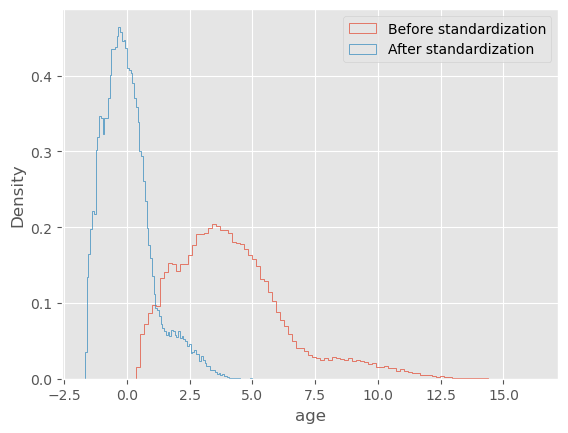

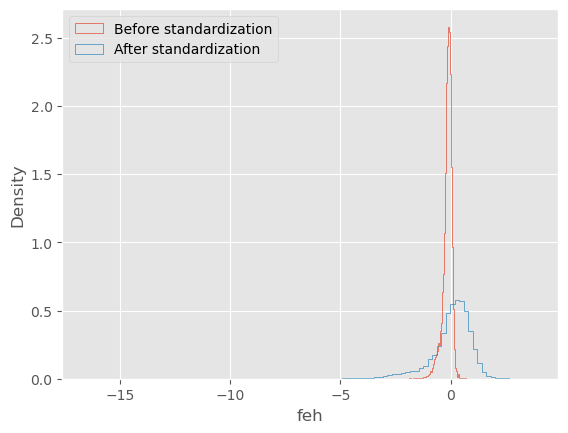

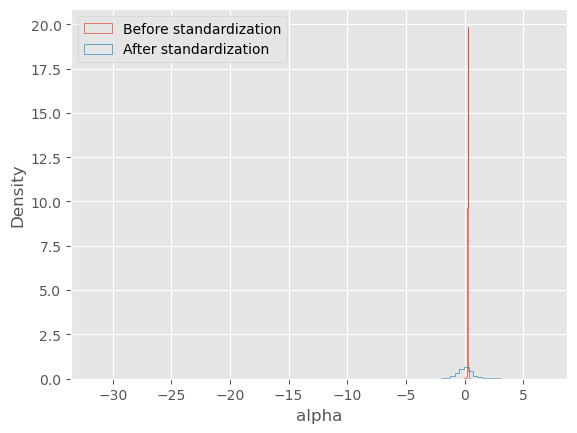

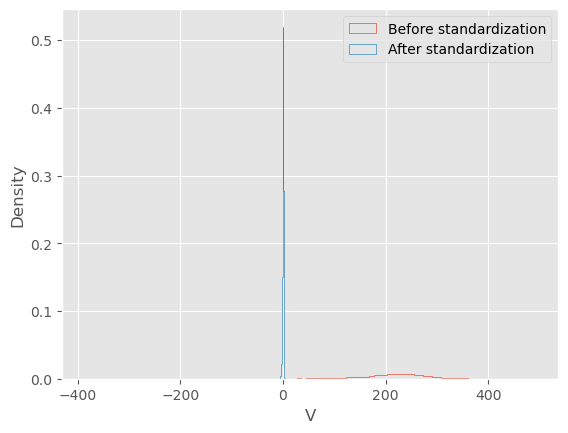

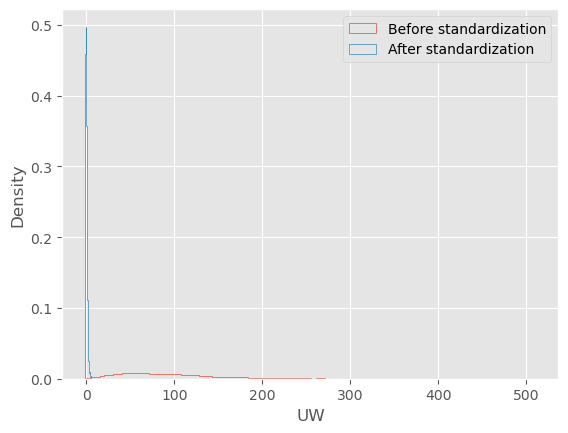

UMAP(min_dist=0.0, n_epochs=10000, verbose=True)
Wed Jul  2 06:10:40 2025 Construct fuzzy simplicial set
Wed Jul  2 06:10:40 2025 Finding Nearest Neighbors
Wed Jul  2 06:10:40 2025 Building RP forest with 19 trees
Wed Jul  2 06:10:40 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Wed Jul  2 06:10:43 2025 Finished Nearest Neighbor Search
Wed Jul  2 06:10:43 2025 Construct embedding


Epochs completed:   0%|            4/10000 [00:02]

	completed  0  /  10000 epochs


Epochs completed:  10%| █          1002/10000 [02:31]

	completed  1000  /  10000 epochs


Epochs completed:  20%| ██         2002/10000 [05:00]

	completed  2000  /  10000 epochs


Epochs completed:  30%| ███        3002/10000 [07:29]

	completed  3000  /  10000 epochs


Epochs completed:  40%| ████       4002/10000 [09:58]

	completed  4000  /  10000 epochs


Epochs completed:  50%| █████      5002/10000 [12:27]

	completed  5000  /  10000 epochs


Epochs completed:  60%| ██████     6002/10000 [14:56]

	completed  6000  /  10000 epochs


Epochs completed:  70%| ███████    7002/10000 [17:25]

	completed  7000  /  10000 epochs


Epochs completed:  80%| ████████   8002/10000 [19:55]

	completed  8000  /  10000 epochs


Epochs completed:  90%| █████████  9002/10000 [22:24]

	completed  9000  /  10000 epochs


Epochs completed: 100%| ██████████ 10000/10000 [24:53]


Wed Jul  2 06:35:43 2025 Finished embedding


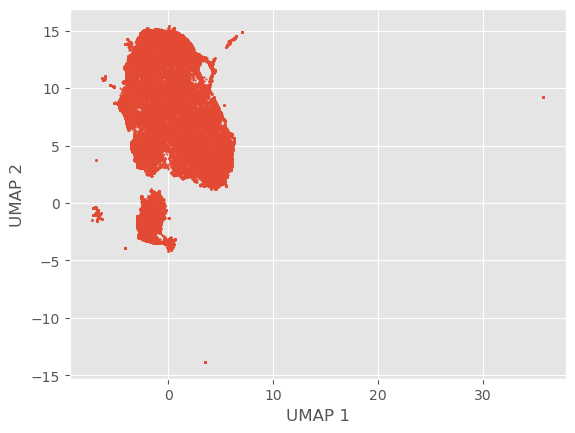

Finding Nearest Neighbours...
Nearest Neighbours found. Time elapsed: 0.361 s
T(k = 15) = 0.977698 after 76168 iterations in 583.334 seconds.


Best trial: 180. Best value: 0.616385: 100%|██████████| 500/500 [1:27:49<00:00, 10.54s/it]
/tmp/ipykernel_778/3412832134.py:95: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
[W 2025-07-02 08:13:16,786] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


With a final score of 0.616, the best parameters are:
 {'min_cluster_size': 987, 'min_samples': 269}


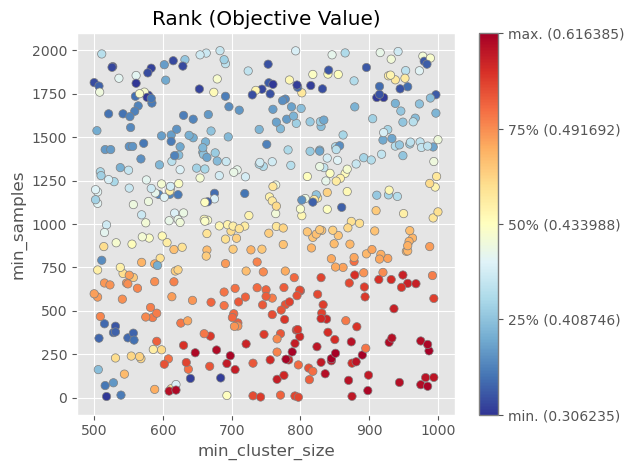

/tmp/ipykernel_778/3412832134.py:102: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])


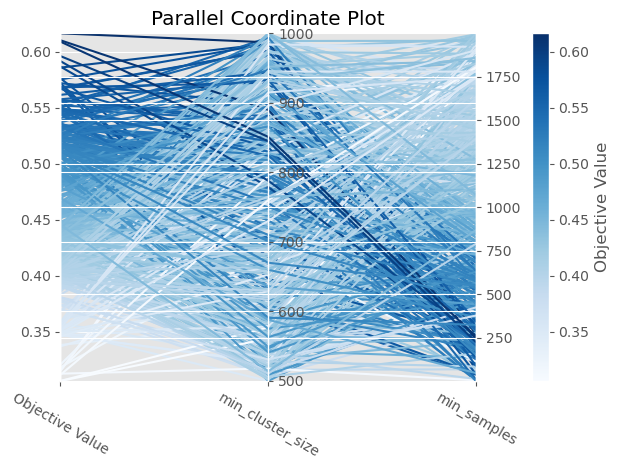

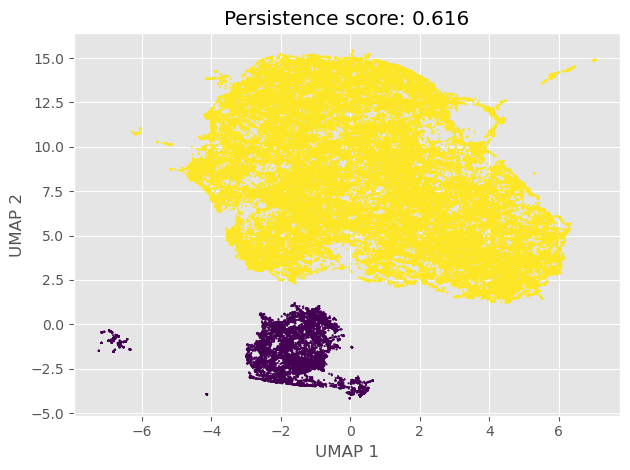

In [22]:
data = pd.read_csv('Ricardo Full Samples/sample_D_m12f-lsr0.csv')
# It is good practice to standardize the data
# There are many different types of standardization
X = StandardScaler().fit_transform(data[interest])

hist_kwargs = {
    'histtype' : 'step',
    'bins'     : 100,
    'density'  : True
}


for i in range(len(interest)):
    plt.hist(
        data[interest].values[:, i],
        label = 'Before standardization',
        **hist_kwargs
    )

    plt.hist(
        X[:, i],
        label = 'After standardization',
        **hist_kwargs
    )

    plt.xlabel(f'{interest[i]}')
    plt.ylabel('Density')
    plt.legend(loc='best')

    plt.show()
plt.close()

# Define UMAP hyperparameters
hyperparameters = {
    'n_neighbors' : 15,
    'min_dist'    : 0.0,
    'n_epochs'    : 10000,
    'verbose'     : True
}

# Run UMAP
model = umap.UMAP(
    **hyperparameters
)

embedding = model.fit_transform(X)


# Plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()
plt.close()

# Make sure that the original space is the one you plugged into the UMAP
t_score = trustworthiness_low_memory(
    X           = X , 
    X_embedding = embedding, 
    k           = 15
)

# Do not show the logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Number of optuna trials
n_trials = 500

# Set up the Optuna study
study_name = f'Sample_HDBSCAN'
study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# Run study (on the embedding)
study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# Get best params and score
best_params = study.best_params
score = study.best_value

print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

# axes = optuna.visualization.matplotlib.plot_slice(study, ['min_cluster_size'])
# axes.set_ylabel('Persistence score')
# axes.set_title('Sample D')
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample D persistance.png',dpi=600)
# plt.show()
# plt.close()

optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample D persistance.png',dpi=600)
plt.show()
plt.close()

optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
plt.plot()
plt.tight_layout()
plt.savefig('Results m12f/Final 1/Sample D Coordinate.png',dpi=600)
plt.show()
plt.close()

# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.plot()
# plt.savefig('Results m12f/Final 1/Sample D Importance.png',dpi=600)
# plt.show()
# plt.close()

# Run HDBSCAN on the embedding
clusterer = hdbscan.HDBSCAN(
        **best_params
    )

clusterer_results = clusterer.fit(embedding)

# Extract labels and persistence score
labels = clusterer_results.labels_
persistence = clusterer_results.cluster_persistence_
persistence_mean = np.mean(clusterer.cluster_persistence_)

data['UMAP1']  = embedding[:, 0]
data['UMAP2']  = embedding[:, 1]
data['labels'] = labels

index = [i for i in range(len(labels)) if labels[i] == -1]
embedding = np.delete(embedding, index,axis=0)
labels = np.delete(labels, index,axis=0)
data = data[data['labels'] != -1]
data.to_csv('Results m12f/Final 1/resultsD.csv', index=False)

# Plot
plt.title(f'Persistence score: {persistence_mean:.3f}')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=labels
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
# plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
plt.show()
plt.close()

# lab = data['labels'].unique()
# m = 0
# for l in lab:
#     if len(data[data['labels'] == m]) < len(data[data['labels'] == l]):
#         m = l
# data = data[data['labels'] == m]

# X = StandardScaler().fit_transform(data[interest])

# hist_kwargs = {
#     'histtype' : 'step',
#     'bins'     : 100,
#     'density'  : True
# }


# for i in range(len(interest)):
#     plt.hist(
#         data[interest].values[:, i],
#         label = 'Before standardization',
#         **hist_kwargs
#     )

#     plt.hist(
#         X[:, i],
#         label = 'After standardization',
#         **hist_kwargs
#     )

#     plt.xlabel(f'{interest[i]}')
#     plt.ylabel('Density')
#     plt.legend(loc='best')

#     plt.show()
# plt.close()

# # Define UMAP hyperparameters
# hyperparameters = {
#     'n_neighbors' : 15,
#     'min_dist'    : 0.0,
#     'n_epochs'    : 10000,
#     'verbose'     : True
# }

# # Run UMAP
# model = umap.UMAP(
#     **hyperparameters
# )

# embedding = model.fit_transform(X)


# # Plot
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1
# )
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')

# plt.show()
# plt.close()

# # Make sure that the original space is the one you plugged into the UMAP
# t_score = trustworthiness_low_memory(
#     X           = X , 
#     X_embedding = embedding, 
#     k           = 15
# )

# # Do not show the logs
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Number of optuna trials
# n_trials = 500

# # Set up the Optuna study
# study_name = f'Sample_HDBSCAN'
# study = optuna.create_study(direction="maximize", study_name=study_name,sampler=sampler)

# # Run study (on the embedding)
# study.optimize(lambda trial: objective(trial, embedding), n_trials=n_trials,show_progress_bar=True)

# # Get best params and score
# best_params = study.best_params
# score = study.best_value

# print(f'With a final score of {score:.3f}, the best parameters are:\n {best_params}')

# optuna.visualization.matplotlib.plot_rank(study, params=['min_cluster_size','min_samples'])
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample D persistance run 2.png',dpi=600)
# plt.show()
# plt.close()

# optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['min_cluster_size','min_samples'])
# plt.plot()
# plt.tight_layout()
# plt.savefig('Results m12f/Final 1/Sample D Coordinate run 2.png',dpi=600)
# plt.show()
# plt.close()

# # optuna.visualization.matplotlib.plot_param_importances(study)
# # plt.plot()
# # plt.savefig('Results m12f/Final 1/Sample A Importance run 2.png',dpi=600)
# # plt.show()
# # plt.close()

# # Run HDBSCAN on the embedding
# clusterer = hdbscan.HDBSCAN(
#         **best_params
#     )

# clusterer_results = clusterer.fit(embedding)

# # Extract labels and persistence score
# labels = clusterer_results.labels_
# persistence = clusterer_results.cluster_persistence_
# persistence_mean = np.mean(clusterer.cluster_persistence_)

# data['UMAP1']  = embedding[:, 0]
# data['UMAP2']  = embedding[:, 1]
# data['labels'] = labels

# index = [i for i in range(len(labels)) if labels[i] == -1]
# embedding = np.delete(embedding, index,axis=0)
# labels = np.delete(labels, index,axis=0)
# data = data[data['labels'] != -1]
# data.to_csv('Results m12f/Final 1/resultsDrun2.csv', index=False)

# # Plot
# plt.title(f'Persistence score: {persistence_mean:.3f}')
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     s=1,
#     c=labels
# )
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.tight_layout()
# # plt.savefig(f'Results m12f/Final 1/SampleA/MCs.png',dpi=300)
# plt.show()
# plt.close()